In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchmtl import MTLModel
from torchmtl.wrapping_layers import Concat
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

# Parameters
batch_size = 64
learning_rate = 0.02
num_epoches = 15
gamma = 0.7
log_interval = 200

In [2]:
# Load dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

PyTorch will run on cuda device


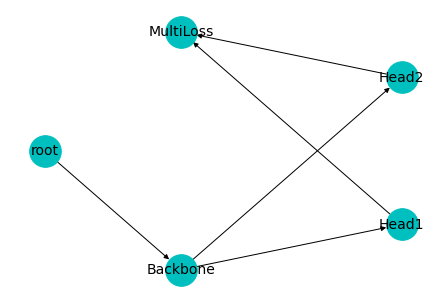

In [3]:
# Define a loss function that returns the log vars
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, num_tasks):
        super(MultiTaskLossWrapper, self).__init__()
        self.num_tasks = num_tasks
        self.log_vars = nn.Parameter(torch.zeros((num_tasks)))

    def forward(self, *X):
        # Return the log vars so precision can be computed
        # in the training loop. Also return the predictions.
        return self.log_vars, X


# Define MTL tasks
tasks = [
        {
            'name': "Backbone",
            'layers': nn.Sequential(*[
                nn.Conv2d(1, 32, 3, 1), 
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, 1), 
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.25),
                nn.Flatten()
                ]),
            # No anchor_layer means this layer receives input directly
        },    
        {
            'name': "Head1",
            'layers': nn.Sequential(*[
                nn.Linear(9216, 256), 
                nn.ReLU(), 
                nn.Dropout(0.5), 
                nn.Linear(256, 10), 
                nn.LogSoftmax(dim=1)
                ]),
            'anchor_layer': "Backbone"
        },    
        {
            'name': "Head2",
            'layers': nn.Sequential(*[
                nn.Linear(9216, 32), 
                nn.ReLU(), 
                nn.Dropout(0.5), 
                nn.Linear(32, 10), 
                nn.LogSoftmax(dim=1)
                ]),
            'anchor_layer': "Backbone"
        },
        {
            'name': "MultiLoss",
            'layers': MultiTaskLossWrapper(num_tasks=2),
            'anchor_layer': ['Head1', 'Head2']
        }
    ]

device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch will run on {device_name} device")
device = torch.device(device_name)
model = MTLModel(tasks, output_tasks=['MultiLoss']).to(device)


# Visualize MTL architecture
pos = nx.shell_layout(model.g)
nx.draw(model.g, pos, font_size=14, node_color="c", node_size=1000, with_labels=True)
plt.show()

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()

        # Predict multi-task outputs
        data, target = data.to(device), target.to(device)
        multi_loss_out, _, _ = model(data)
        log_vars = multi_loss_out[0][0]
        softmax_out = multi_loss_out[0][1]
        task_num = len(softmax_out)

        # Compute loss of each task and weight them
        loss = 0
        for i in range(task_num):
            precision = torch.exp(-log_vars[i])
            diff = F.nll_loss(softmax_out[i], target)
            loss += torch.sum(precision * diff + log_vars[i], -1)
        loss = torch.mean(loss)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        log_vars = log_vars.cpu().detach().numpy().copy()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSigma: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), np.sqrt(np.exp(log_vars))))

    return train_loss * train_loader.batch_size / len(train_loader.dataset), log_vars

In [5]:
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train_losses = []
params = []
for epoch in range(1, num_epoches + 1):
    
    train_loss, param = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    params.append(param)

    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.661347	Sigma: [1.0000316 1.0000316]
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.669427	Sigma: [1.0010552 1.0056251]
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.405144	Sigma: [0.9884001 1.0041252]
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.055774	Sigma: [0.97219324 0.9966178 ]
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.687395	Sigma: [0.95415205 0.9868841 ]
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.870839	Sigma: [0.9411384  0.97886926]
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.709615	Sigma: [0.9270749  0.97013974]
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.513418	Sigma: [0.91281545 0.96111554]
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.414846	Sigma: [0.8983409 0.9520952]
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.591800	Sigma: [0.88374966 0.9427753 ]
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.258336	Sigma: [0.87354386 0.9363853 ]
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.254737	Sigma: [0.86306566 0.92972887]
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.290085	S

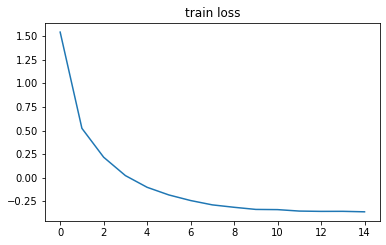

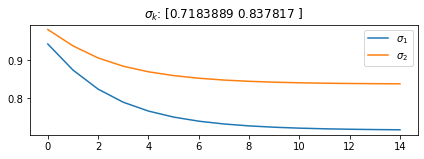

In [6]:
# Visualize the overall loss 
plt.figure(figsize=(6, 8))
plt.subplot(211)
plt.title('train loss')
plt.plot(train_losses)
plt.show()

# Visualize the overall sigmas
sigmas = np.sqrt(np.exp(params))

plt.subplot(212)
plt.title(r'$\sigma_k$: ' + f'{sigmas[-1]}')
plt.plot(sigmas[:, 0])
plt.plot(sigmas[:, 1])
plt.legend([r'$\sigma_1$', r'$\sigma_2$'])

plt.tight_layout()
plt.show()